In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append('/dfs/scratch0/vschen/metal')

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Simulate

target op: 0.1, found op: 0.10573333333333333, found r: 1.6000000000000008
target recall: 0.95, found cov: 0.95, found r: 4.259999999999954
target recall: 0.95, found cov: 0.9503759398496241, found r: 5.699999999999923
target recall: 0.95, found cov: 0.9564705882352941, found r: 1.5800000000000012


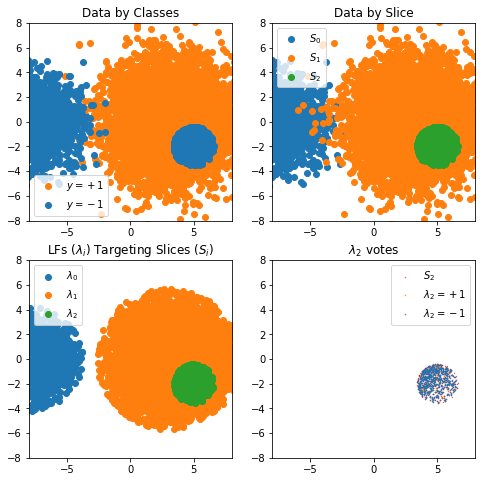

{'N': 10000,
 'mus': [array([-8,  0]), array([3, 0])],
 'labels': [-1, 1],
 'props': [0.25, 0.75],
 'variances': [3, 5],
 'head_config': {'h': 5, 'k': -2, 'r': 1, 'slice_label': -1},
 'accs': array([0.9, 0.9, 0.9]),
 'covs': [('recall', 0.95), ('recall', 0.95), ('recall', 0.95)]}

In [17]:
from simulate import data_config as config
from synthetics_utils import generate_synthetic_data
from visualization_utils import visualize_data
config['head_config']['h'] = 5
config['head_config']['k'] = -2
config['covs'] = [('recall', 0.95), ('recall', 0.95), ('recall', 0.95)]
X, Y, C, L = generate_synthetic_data(config, 'sp', 0.1)

# L[L[:, 2] != 0, 2] = 0 # remove LF2 to show data underneath
visualize_data(X, Y, C, L)
config

In [18]:
from simulate import eval_model
def eval_on_slices(model, X_test, Y_test, C_test):
    S0_idx, S1_idx, S2_idx = (
        np.where(C_test == 0)[0],
        np.where(C_test == 1)[0],
        np.where(C_test == 2)[0],
    )
    eval_dict = {"S0": S0_idx, "S1": S1_idx, "S2": S2_idx}

    preds, Y = model._get_predictions((X_test, Y_test), return_probs=False)
    
    print ("S0:", np.sum((preds == Y)[S0_idx]) / len(Y[S0_idx]))
    print ("S1:", np.sum((preds == Y)[S1_idx]) / len(Y[S1_idx]))
    print ("S2:", np.sum((preds == Y)[S2_idx]) / len(Y[S2_idx]))
    

split_idx = int(len(X) * 0.8)

X = torch.Tensor(X)
# X = X.astype(np.float32)
Y_cat = Y.copy().astype(np.int32)
Y_cat[Y==-1] = 2
X_train, X_test = X[:split_idx], X[split_idx:]
Y_train, Y_test = Y_cat[:split_idx], Y_cat[split_idx:]
L_train, L_test = L[:split_idx], L[split_idx:]
C_train, C_test = C[:split_idx], C[split_idx:]

In [19]:
from metal.contrib.slicing.experiment_utils import generate_weak_labels
accs = config['accs']
Y_tilde = generate_weak_labels(L_train, accs)

In [20]:
from metal.end_model import EndModel
from metal.contrib.slicing.online_dp import SliceDPModel, MLPModule

model_configs = {
    "EndModel": {
        "base_model_class" : EndModel,
        "input_module_class": MLPModule,
        "input_module_init_kwargs": {
            'input_dim': 2,
            'middle_dims': [10, 10],
            'bias': True,
            'output_dim': 10
         },
        "base_model_init_kwargs": {
            "layer_out_dims": [10, 2],
            "input_layer_config": {
                "input_relu": False,
                "input_batchnorm": False, 
                "input_dropout": 0.0,
            }
        },
        "train_on_L": False
    },
    "UniformModel": {
        "base_model_class" : SliceDPModel,
        "base_model_init_kwargs": {
            "accs": accs,
            "reweight": False,
            "r": 10,
            "slice_weight": 0.5,
            "L_weights": np.array([1., 1., 1.]).astype(np.float32)
        },
        "input_module_class": MLPModule,
        "input_module_init_kwargs": {
            'input_dim': 2,
            'middle_dims': [10, 10],
            'bias': True,
            'output_dim': 10
         },
        "train_on_L": True
    },
    "ManualModel": {
        "base_model_class" : SliceDPModel,
        "base_model_init_kwargs": {
            "accs": accs,
            "reweight": False,
            "r": 10,
            "slice_weight": 0.5,
            "L_weights": np.array([1., 1., 5.]).astype(np.float32) # LF2 5x weight
        },
        "input_module_class": MLPModule,
        "input_module_init_kwargs": {
            'input_dim': 2,
            'middle_dims': [10, 10],
            'bias': True,
            'output_dim': 10
         },
        "train_on_L": True
    },
    "AttentionModel": {
        "base_model_class" : SliceDPModel,
        "base_model_init_kwargs": {
            "accs": accs,
            "reweight": True,
            "r": 10,
            "slice_weight": 0.5,
            "L_weights": None
        },
        "input_module_class": MLPModule,
        "input_module_init_kwargs": {
            'input_dim': 2,
            'middle_dims': [10, 10],
            'bias': True,
            'output_dim': 10
         },
        "train_on_L": True,
    }
}

train_kwargs = {
    "lr": 0.005,
    "n_epochs": 20,
    "disable_prog_bar": True,
    "print_every": 1,
    "checkpoint_runway":5
}

from simulate import train_models
trained_models = train_models(X_train, L_train, Y_tilde, (X_test, Y_test), accs, model_configs, train_kwargs, verbose=True, seed=123)
for model_name, model in trained_models.items():
    print (model_name)
    eval_on_slices(model, X_test, Y_test, C_test)

---------- Training EndModel ----------

Network architecture:
Sequential(
  (0): MLPModule(
    (input_layer): Sequential(
      (0): Linear(in_features=2, out_features=10, bias=True)
      (1): ReLU()
      (2): Linear(in_features=10, out_features=10, bias=True)
      (3): ReLU()
      (4): Linear(in_features=10, out_features=10, bias=True)
      (5): ReLU()
    )
  )
  (1): Linear(in_features=10, out_features=2, bias=True)
)

No checkpoints will be saved in the first checkpoint_runway=5 iterations.
[E:0]	Train Loss: 0.458	Dev accuracy: 0.906
[E:1]	Train Loss: 0.431	Dev accuracy: 0.908
[E:2]	Train Loss: 0.426	Dev accuracy: 0.910
[E:3]	Train Loss: 0.425	Dev accuracy: 0.910
[E:4]	Train Loss: 0.424	Dev accuracy: 0.910
Saving model at iteration 5 with best score 0.910
[E:5]	Train Loss: 0.423	Dev accuracy: 0.910
[E:6]	Train Loss: 0.421	Dev accuracy: 0.907
[E:7]	Train Loss: 0.420	Dev accuracy: 0.909
[E:8]	Train Loss: 0.418	Dev accuracy: 0.910
[E:9]	Train Loss: 0.419	Dev accuracy: 0.905
[E:

In [ ]:
# # %%time
# from simulate import simulate, data_config, experiment_config

# experiment_config['x_var'] = 'cov.precision'
# experiment_config['num_trials'] = 1
# # experiment_config['x_range'] = np.linspace(0.55, 0.95, 5)
# experiment_config['x_range'] = [0.5, 0.6, 0.7, 0.8, 0.9]
# # experiment_config['x_range'] = [0.5]
# experiment_config["train_kwargs"]['print_every'] = 10
# scores = \
#     simulate(config, generate_synthetic_data, experiment_config, model_configs)

# scores

In [ ]:
# def get_slice_scores(scores, key=0.9):
#     S0 = np.mean([s['S0'] for s in scores[key]])
#     S1 = np.mean([s['S1'] for s in scores[key]])
#     S2 = np.mean([s['S2'] for s in scores[key]])
#     overall = np.mean([s['overall'] for s in scores[key]])    
#     return {'S0':S0, 'S1':S1, 'S2':S2, 'overall':overall}

In [ ]:
# for model_name, model_scores in scores.items():
#     print ('-'*10, model_name, '-'*10)
#     for k in model_scores.keys():
#         print (k, get_slice_scores(model_scores, k))

In [ ]:
# from visualization_utils import plot_slice_scores
# xlabel="Head LF ($\lambda_2$) Accuracy"
# plt.figure(figsize=(10, 10))
# plt.subplot(2, 2, 1)
# plot_slice_scores(scores, "S2", xlabel=xlabel)
# plt.subplot(2, 2, 2)
# plot_slice_scores(scores, "S1", xlabel=xlabel)
# plt.subplot(2, 2, 3)
# plot_slice_scores(scores, "S0", xlabel=xlabel)
# plt.subplot(2, 2, 4)
# plot_slice_scores(scores, "overall", xlabel=xlabel)